In [5]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import ToktokTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import RSLPStemmer
import numpy as np
import spacy
nlp = spacy.load("en_core_web_sm")
import plotly.express as px
import string
import joblib

[nltk_data] Downloading package stopwords to /Users/baia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /Users/baia/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## Criar uma funcao que recebera um product_id e voltara o mapa de palavras correspondente aos reviews dados

- filtrar o produto desejado
- realizar o pré-processamento
- plotar a nuvem de palavras

In [6]:
reviews = pd.read_csv("/Users/baia/Desktop/PYTHON/repo-dsa/data-science-analytics/reviews-sentiment-analysis/data/raw/Reviews.csv")
reviews

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [7]:
score_counts = reviews['Score'].value_counts(normalize=True).sort_index() * 100
df_score_percent = score_counts.rename_axis('Score').reset_index(name='Percent')
df_score_percent



,Score,Percent
0,1,9.194763
1,2,5.236835
2,3,7.501047
3,4,14.188483
4,5,63.878871


# Limpeza do texto ...

In [8]:
from textblob import TextBlob # Serve para tarefas rápidas de correção ortográfica em inglês. (utiliza um dicionario embutido)
from autocorrect import Speller # Uma segunda alternativa para correcao, este [e mais leve, porém menos preciso
from nltk.stem import RSLPStemmer
import string
import re

# AQUI você cria o corretor de inglês
spell = Speller(lang='en')

# Informações do produto a ser analisado
product_id = 'B001EO5Q64'
product_name = 'PRoduct Coconut Oil'

# Palavras do nome do produto, removendo stopwords e mantendo apenas palavras alfabéticas
forbbiden_words = [word.lower() for word in product_name.split() if word not in stopwords.words('english') and word.isalpha()]

# Classificador de Score
def classificar_score(score):
    if score <= 2:
        return 'Negativo'
    elif score == 3:
        return 'Neutro'
    elif score >= 4:
        return 'Positivo'
    else:
        return 'Desconhecido'

# Limpeza do texto
df_formatado = (
    # Seleciona as colunas relevantes e aplica as transformações
    reviews.loc[reviews['ProductId'] == product_id, ['Time', 'ProductId', 'Summary', 'Score', 'Text']]
    # reviews.loc[reviews['ProductId'] != product_id, ['Time', 'ProductId', 'Summary', 'Score', 'Text']]
    .assign(
        formated_text=lambda df: df['Text']
            .str.replace(r'<.*?>', '', regex=True)                      # Remove HTML tags
            .str.translate(str.maketrans('', '', string.punctuation))   # Remove prontuação
            .str.replace(r'\s+', ' ', regex=True)                       # Remove espaços extras
            .str.strip()                                                # Remove espaços no início e no fim
            .str.replace(r'\b\w{1,2}\b', '', regex=True)                # Remove palavras com 1 ou 2 letras
            .str.replace(r'\b\w{30,}\b', '', regex=True)                # Remove palavras com mais de 30 letras
            .str.lower()                                                # Lowercase
            .str.replace(r'\d+', '', regex=True)                        # Remove números
            .apply(spell)                                               # Correção ortográfica
            .apply(lambda text: ' '.join([w for w in text.split() if w not in forbbiden_words]))  # Remove palavras do nome do produto
    )
    .assign(
        classificacao=lambda df: df['Score']                            # Classifica em Pos, neu ou neg
            .apply(classificar_score)
    )
    .assign(
        Time=lambda df: pd.to_datetime(df['Time'], unit='s')            # Convertendo timestamp para datetime
    )
    .sort_values(by='Time', ascending=False)                            # Ordena por data
    .reset_index(drop=True)                                             # Reseta o índice
)

df_formatado

,Time,ProductId,Summary,Score,Text,formated_text,classificacao
0,2012-10-23,B001EO5Q64,"Love, Love, Love...",5,"This is my favorite, hands-down, brand of coco...",this favorite handsdown brand use cookingfave ...,Positivo
1,2012-10-23,B001EO5Q64,Great for your hair!,5,I bought this product to help condition my hai...,bought this help condition hair and works grea...,Positivo
2,2012-10-23,B001EO5Q64,Used For Hair and Skin,5,This is my 3rd shipment that I received from A...,this rd shipment that received from amazon and...,Positivo
3,2012-10-20,B001EO5Q64,Kerry's Comments -,5,"This stuff ""Nutiva Organic Extra Virgin Coconu...",this stuff native organic extra virgin ounce s...,Positivo
4,2012-10-18,B001EO5Q64,Best tasting oil,5,"""Product arrived quickly, packaged well. Love ...",arrived quickly packaged well love the taste f...,Positivo
...,...,...,...,...,...,...,...
562,2008-06-05,B001EO5Q64,Awesome coconut tasting coconut oil!,5,We love this coconut oil. We use it for cooki...,love this use for cooking and for body care sm...,Positivo
563,2008-04-19,B001EO5Q64,A Great Product,5,This product is awesome. It has a wonderful t...,this awesome has wonderful taste and gives bak...,Positivo
564,2007-07-27,B001EO5Q64,small size for the price,4,This oil is not as opaque as pictured. I made...,this not opaque pictured made delicious ice cr...,Positivo
565,2007-04-09,B001EO5Q64,"GREAT COCONUT OIL....Try it, you'll like it!",5,Nutiva is the BEST COCONUT OIL! I love it and ...,native the best love and you will too youre lo...,Positivo


In [9]:
# df_formatado.to_csv('/Users/baia/Desktop/PYTHON/repo-dsa/data-science-analytics/reviews-sentiment-analysis/data/processed/reviews_formatado.csv', index=False)

## Realizar a tokenização ..

- Se seu objetivo for análise de sentimento rápida, não precisa aplicar stemming!
- Só a lemmatização + remoção de stopwords já é o suficiente.
- Stemming é mais útil em casos de classificação de texto ou redução de vocabulário.

In [10]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# Setar as stopwords
stopwords_en = set(stopwords.words('english'))
stopwords_en

# Instanciar o tokenizer
tokenizer = ToktokTokenizer()

# Função que irá tokenizar tudo em uma unica linha e remover as stopwords
def tokenizerIt(columns: str) -> str:
    # Filtrando os tokens com base nas stopswords
    return [tokens for tokens in tokenizer.tokenize(columns) if tokens not in stopwords_en and tokens.isalpha()]

# Função para realizar o stemming da palavra
def stemmer(cells: str):
    # Instanciando o stemmer
    stemmer = RSLPStemmer()
    stemmed_counts = []
    
    for word in cells:
        stem = stemmer.stem(word)
        stemmed_counts.append(stem)

    return stemmed_counts

# Função para lematizar a lista de tokens
def lemmatize_tokens(tokens: list) -> list:
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

# o lemmatizer entende o significado; o stemmer é um triturador que simplifica depois.

df_tokens = (df_formatado
 
 # Tokenizar o texto formatado para o padrão proposto
 .assign(tokens = lambda df: df['formated_text'].apply(tokenizerIt))

 # Lemmatizar os tokens (é feito antes do counter, para evitar que a msm palavra, escrita de formas diferentes, seja contabilizada)
 # Reduz palavras à sua forma base canônica (mais linguístico e inteligente) "correu -> correr"
 # O lemmatizer é mais lento, mas mais preciso que o stemmer
 .assign(lemma_text = lambda df: df['tokens'].apply(lemmatize_tokens))

 # Realizar um groupby de todas as palavras em uma unica lista
 .groupby('classificacao', as_index=False)  
 .agg({'tokens':'sum','lemma_text': 'sum'})         

# Remoção das palavras com menos de 3 caracteres
.assign(lemma_text = lambda df: df['lemma_text'].apply(lambda tokens: [tokens for tokens in tokens if len(tokens) > 2]))

# Aplicando counter para saber a quantidade de palavras por classificação
.assign(counter_lemma = lambda df: df['lemma_text'].apply(lambda tokens: Counter(tokens)))
 
)

df_tokens

[nltk_data] Downloading package wordnet to /Users/baia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,classificacao,tokens,lemma_text,counter_lemma
0,Negativo,"[well, didnt, even, ship, house, returned, mon...","[well, didnt, even, ship, house, returned, mon...","{'well': 2, 'didnt': 1, 'even': 3, 'ship': 1, ..."
1,Neutro,"[good, priceywhen, signed, subscription, less,...","[good, priceywhen, signed, subscription, less,...","{'good': 3, 'priceywhen': 1, 'signed': 1, 'sub..."
2,Positivo,"[favorite, handsdown, brand, use, cookingfave,...","[favorite, handsdown, brand, use, cookingfave,...","{'favorite': 17, 'handsdown': 1, 'brand': 133,..."


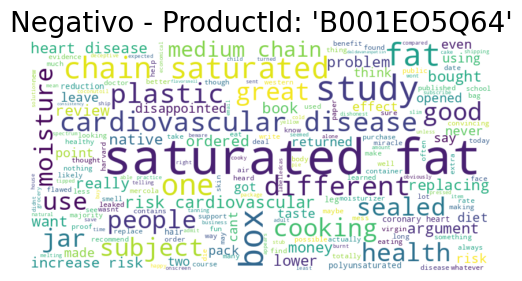

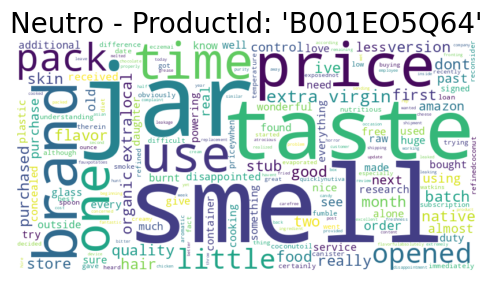

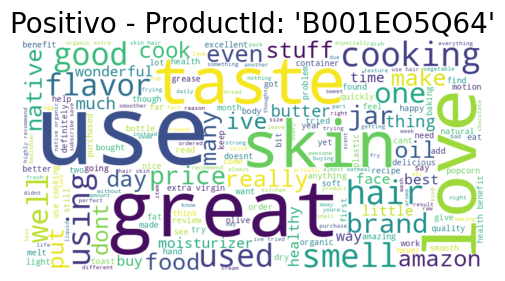

In [11]:
# Correção do loop e concatenação dos tokens por classificação
for idx, row in df_tokens.iterrows():
    sentimento = row['classificacao']
    all_words = ' '.join(row['lemma_text'])
    # print(all_words)

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_words)

    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentimento} - ProductId: '{product_id}'", fontsize=20)
    plt.show()

# Tabela com a quantidade de de top vozes de cada sentimento e a sua frequencia

In [12]:
for idx, row in df_tokens.iterrows():

    df_temp = pd.DataFrame(row['counter_lemma'].most_common(20), columns=['Word', 'Count']).assign(classificacao=row['classificacao'])
    sentimento = row['classificacao']
    df_table = pd.concat([df_table, df_temp], ignore_index=True) if 'df_table' in locals() else df_temp
    
df_table

,Word,Count,classificacao
0,fat,31,Negativo
1,saturated,24,Negativo
2,risk,12,Negativo
3,disease,12,Negativo
4,like,10,Negativo
5,study,10,Negativo
6,box,9,Negativo
7,one,7,Negativo
8,chain,7,Negativo
9,plastic,6,Negativo


## Tabela com a quantidade de top vozes de cada sentimento (NLP)

In [13]:
# Carrega modelo do spaCy em inglês
nlp = spacy.load("en_core_web_sm")

# Carregar stopwords do NLTK
stopwords_en = set(stopwords.words('english'))

In [14]:
for sentimento in df_tokens['classificacao'].unique():    
    # 1. Juntar todas as mensagens de avaliações nota 1
    df_positivo = df_formatado.query(rf"classificacao == '{sentimento}'")
    texto_unico = ' '.join(df_positivo['formated_text'])

    # 2. Processar texto com spaCy
    doc = nlp(texto_unico)

    # 3. Filtrar tokens relevantes: sem stopwords, sem pontuação, apenas palavras significativas
    palavras_filtradas_positivas = [
        token.lemma_ for token in doc
        if token.is_alpha and                         # apenas palavras (sem números/símbolos)
        token.lemma_ not in stopwords_en and       # remove stopwords
        len(token.lemma_) > 2 and                  # remove palavras muito curtas
        token.pos_ in ['NOUN', 'VERB', 'ADJ']      # apenas substantivos, verbos e adjetivos
    ]

    # 4. Contar as 20 palavras mais frequentes
    palavras_mais_comuns = Counter(palavras_filtradas_positivas).most_common(20)

    # 5. Criar gráfico diretamente a partir da lista de tuplas
    fig = px.bar(
        x=[item[0] for item in palavras_mais_comuns],
        y=[item[1] for item in palavras_mais_comuns],
        labels={'x': 'Palavra (com stemming)', 'y': 'Frequência'},
        title=rf'Top 20 Palavras Mais Frequentes com Stemming (Avaliações {sentimento})',
        text=[item[1] for item in palavras_mais_comuns]  # mostra valor fora da barra
    )

    # Ajustes visuais
    fig.update_traces(marker_color='indianred', textposition='outside')
    fig.update_layout(
        height=300,
        plot_bgcolor='white',
        xaxis=dict(tickfont=dict(size=14)),
        yaxis=dict(tickfont=dict(size=14))
    )

    fig.show()

## SERIES TEMPORAIS DE AVALIACOES NEG X POST

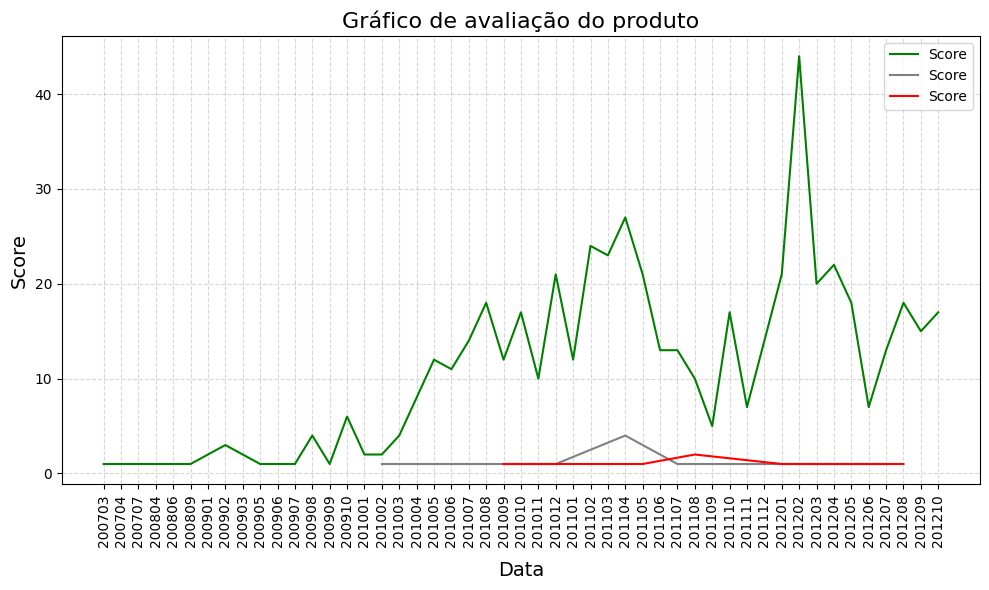

In [15]:
df_tseries = (df_formatado
              .assign(Year=lambda df: df['Time'].dt.year)
              .assign(year_month=lambda df: df['Time'].dt.strftime('%Y%m'))
              .groupby(['Year', 'year_month','classificacao'], as_index=False).agg(count=('ProductId', 'count'))
              )

df_positivo = df_tseries.query("classificacao == 'Positivo'")
df_neutro = df_tseries.query("classificacao == 'Neutro'")
df_negativo = df_tseries.query("classificacao == 'Negativo'")

# Definindo o tamnho da figura
fix, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_positivo['year_month'], df_positivo['count'], linestyle='-', color='green', label='Score')
ax.plot(df_neutro['year_month'], df_neutro['count'], linestyle='-', color='grey', label='Score')
ax.plot(df_negativo['year_month'], df_negativo['count'], linestyle='-', color='red', label='Score')

# Configuracões adicionais
ax.set_title('Gráfico de avaliação do produto', fontsize=16)
ax.set_xlabel('Data', fontsize=14, labelpad=10)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Score', fontsize=14)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# formatação do eixo X para datas
plt.tight_layout()
plt.show()

## Classificação de sentimento do produto

- Para realizar a analise de sentimento, é necessário:
- deixar a frase em ingles
- Aplicar algoritmos de analise do texto
- Não é necessário realizar a lemmantizacao e nem o stemming, apenas a correcao ortográfica do texto em ingles

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from textblob import TextBlob
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.express as px
import string

[nltk_data] Downloading package stopwords to /Users/baia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /Users/baia/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [17]:
# Inicializar o analisador de sentimentos VADER
# Este analise textos apenas em ingles e os classifica como neutro, negativo e positivo em uma escala que vai de 0 a 1'
sia = SentimentIntensityAnalyzer()

In [14]:
# Função para categorizar o sentimento
def classify_sentiment(score):
    if score >= 0.05:
        return "Positivo"
    elif score <= -0.05:
        return "Negativo"
    else:
        return "Neutro"

(df_formatado
 
 # polarity - Mede o sentimento geral do texto, variando de -1 (muito negativo) a +1 (muito positivo).
 # subjectivity	- Mede o quão subjetivo (opinião) ou objetivo (fato) é o texto, variando de 0 (fato) a 1 (opinião).

 .assign(polarity_blob = lambda df: df['formated_text'].apply(lambda row: TextBlob(row).sentiment.polarity))
 .assign(subjectivity_blob = lambda df: df['formated_text'].apply(lambda row: TextBlob(row).sentiment.subjectivity))
 # sentimentos VADER
 .assign(sia_compound = lambda df: df['formated_text'].apply(lambda row: sia.polarity_scores(row)['compound']))

#  Classifica o sentimento do texto
 .assign(sentimento_sia = lambda df: df['sia_compound'].apply(lambda row: classify_sentiment(row)))

#  # Realizar o groupby e agregar os valores de sentimento
#  .groupby('ProductId', as_index=False)
#  .agg(
#       polaridade=('polarity_blob', np.mean), 
#       subjetividade=('subjectivity_blob', np.mean), 
#       positivo=('sentimento_sia', lambda x: (x == 'positivo').sum()),
#       neutro=('sentimento_sia', lambda x: (x == 'neutro').sum()),
#       negativo=('sentimento_sia', lambda x: (x == 'negativo').sum())
#       )
 
 
).query("classificacao == sentimento_sia")

,Time,ProductId,Summary,Score,Text,formated_text,classificacao,polarity_blob,subjectivity_blob,sia_compound,sentimento_sia
0,2012-10-23,B001EO5Q64,"Love, Love, Love...",5,"This is my favorite, hands-down, brand of coco...",this favorite handsdown brand use cookingfave ...,Positivo,0.216667,0.637037,0.9325,Positivo
1,2012-10-23,B001EO5Q64,Great for your hair!,5,I bought this product to help condition my hai...,bought this help condition hair and works grea...,Positivo,0.900000,0.875000,0.8765,Positivo
2,2012-10-23,B001EO5Q64,Used For Hair and Skin,5,This is my 3rd shipment that I received from A...,this rd shipment that received from amazon and...,Positivo,0.264603,0.485714,0.9386,Positivo
3,2012-10-20,B001EO5Q64,Kerry's Comments -,5,"This stuff ""Nutiva Organic Extra Virgin Coconu...",this stuff native organic extra virgin ounce s...,Positivo,0.113636,0.322727,0.7269,Positivo
4,2012-10-18,B001EO5Q64,Best tasting oil,5,"""Product arrived quickly, packaged well. Love ...",arrived quickly packaged well love the taste f...,Positivo,0.248485,0.515152,0.9403,Positivo
...,...,...,...,...,...,...,...,...,...,...,...
562,2008-06-05,B001EO5Q64,Awesome coconut tasting coconut oil!,5,We love this coconut oil. We use it for cooki...,love this use for cooking and for body care sm...,Positivo,0.218750,0.643750,0.9337,Positivo
563,2008-04-19,B001EO5Q64,A Great Product,5,This product is awesome. It has a wonderful t...,this awesome has wonderful taste and gives bak...,Positivo,0.266667,0.615152,0.9559,Positivo
564,2007-07-27,B001EO5Q64,small size for the price,4,This oil is not as opaque as pictured. I made...,this not opaque pictured made delicious ice cr...,Positivo,0.433333,0.547222,0.8395,Positivo
565,2007-04-09,B001EO5Q64,"GREAT COCONUT OIL....Try it, you'll like it!",5,Nutiva is the BEST COCONUT OIL! I love it and ...,native the best love and you will too youre lo...,Positivo,0.553333,0.480000,0.8555,Positivo


## Separação da base em conjunto de teste e treinamento

- Aqui utilizaremos a técnica de undersampling, pois a quantidade de notas positivas é bem maior que as demais classes

In [ ]:
reviews['sentimento'] = reviews['Score'].apply(classificar_score)

# Se o número de avaliações de alguma classe for maior que 50% do total, reduz para 50% do total de amostras a serem utilizadas durante o treinamento
# Caso contrário, mantém o número de avaliações como está
# Isso é feito para balancear as classes de sentimento, evitando que o modelo fique enviesado
df_concatenado = pd.DataFrame()

for sentimento in reviews['sentimento'].unique():
    df = reviews.query(f"sentimento == '{sentimento}'")
    df_reduzido = pd.DataFrame()

    if len(df) > len(reviews) / 2:
        df_reduzido = df.sample(n=len(reviews) - len(df), random_state=42)  # 50% do total de avaliações serão positivas
    else:
        df_reduzido = df

    df_concatenado = pd.concat([df_reduzido, df_concatenado], ignore_index=True)

df_balanceado = (df_concatenado
                    .assign(
                        formated_text=lambda df: df['Text']
                            .str.replace(r'<.*?>', '', regex=True)                      # Remove HTML tags
                            .str.translate(str.maketrans('', '', string.punctuation))   # Remove prontuação
                            .str.replace(r'\s+', ' ', regex=True)                       # Remove espaços extras
                            .str.strip()                                                # Remove espaços no início e no fim
                            .str.replace(r'\b\w{30,}\b', '', regex=True)                # Remove palavras com mais de 30 letras
                            .str.lower()                                                # Lowercase
                            .str.replace(r'\d+', '', regex=True)                        # Remove números
                            .apply(lambda text: ' '.join([w for w in text.split() if w not in forbbiden_words]))  # Remove palavras do nome do produto
            ))
                          
df_balanceado

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentimento,formated_text
0,46,B001EO5QW8,A39Z97950MCTQE,K. A. Freel,0,0,3,1205193600,Hearty Oatmeal,This seems a little more wholesome than some o...,Neutro,this seems a little more wholesome than some o...
1,48,B001EO5QW8,A26AY1TFK8BQXQ,"kbogo ""shoelover""",1,2,3,1200096000,Mushy,"The flavors are good. However, I do not see a...",Neutro,the flavors are good however i do not see any ...
2,50,B001EO5QW8,A276999Y6VRSCQ,JMay,0,1,3,1334016000,Same stuff,This is the same stuff you can buy at the big ...,Neutro,this is the same stuff you can buy at the big ...
3,54,B000G6RPMY,AQ9DWWYP2KJCQ,"Roel Trevino ""protomex""",0,0,3,1278028800,not ass kickin,we're used to spicy foods down here in south t...,Neutro,were used to spicy foods down here in south te...
4,61,B004N5KULM,A1ZR8O62VSU4OK,"Lisa J. Szlosek ""lisa""",2,4,3,1318723200,Better price for this at Target,Watch your prices with this. While the assort...,Neutro,watch your prices with this while the assortme...
...,...,...,...,...,...,...,...,...,...,...,...,...
249349,197640,B0011EO7WQ,A15H73KHFVDRCW,nevada,20,23,5,1298419200,Great Product,I purchased after reading many reviews. Use o...,Positivo,i purchased after reading many reviews use on ...
249350,289802,B00436SFOK,A2OR94VN7XQCUO,"Edward Scott ""ewscott""",1,1,4,1307577600,Yeah I like my coffee in the morning,But that first cup is made before my last rema...,Positivo,but that first cup is made before my last rema...
249351,19690,B0030VBRIU,A2IRI9FQ3Y2THO,MomHaydee,0,0,5,1315267200,Great texture and tastes delicious,The Happy Baby Chick Chick is delicious and my...,Positivo,the happy baby chick chick is delicious and my...
249352,341647,B001RVFEP2,A1VXTRVD6NI8Y6,"Disney Fan ""Thoroughly Hooked""",0,0,5,1229040000,Great Snack!,"we love Pop Chips, but they ceased being avail...",Positivo,we love pop chips but they ceased being availa...


É essencial usar a divisão estratificada. Isso garante que a proporção de classes no seu novo dataset balanceado seja a mesma tanto no conjunto de treino quanto no de teste. Isso evita que, por azar, o conjunto de teste tenha uma proporção de classes muito diferente do de treino, o que levaria a uma avaliação de performance incorreta.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

# Supondo que 'X' são suas features (texto do review) e 'y' é a coluna 'sentimento'
X = df_balanceado['formated_text']
y = df_balanceado['sentimento']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,      # Ou 0.2, 0.3, dependendo da sua preferência
    stratify=y,          # <-- O PARÂMETRO MAIS IMPORTANTE!
    random_state=42      # Para reprodutibilidade
)

# 1. Criar um Pipeline que combina o vetorizador e o modelo
# Isso garante que os dados de validação dentro do GridSearchCV não "vazem" para o treinamento, tornando a avaliação mais robusta.
pipeline = Pipeline([ 
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

# 2. Definir a grade de parâmetros que você quer testar
# A sintaxe é 'nome_da_etapa__nome_do_parâmetro'
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],  # Testa unigramas e bigramas
    'vect__max_df': (0.5, 0.75, 1.0),      # Ignora palavras muito frequentes
    'clf__alpha': (0.1, 0.5, 1.0),         # Parâmetro de suavização do Naive Bayes
}

# 3. Criar e treinar o GridSearchCV
# cv=5 significa 5-fold cross-validation
# n_jobs=-1 usa todos os processadores disponíveis para acelerar
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Mostrar os melhores parâmetros encontrados
print("Melhores parâmetros encontrados: ", grid_search.best_params_)

# Mostrar a melhor acurácia durante o cross-validation
print("Melhor acurácia (CV): ", grid_search.best_score_)

# Avaliar o melhor modelo encontrado no conjunto de teste
best_model = grid_search.best_estimator_
accuracy_test = best_model.score(X_test, y_test)
print("Acurácia no conjunto de teste: ", accuracy_test)

# 74359 / 525814 = 14.15% de diferença entre o verdadeiro sentimento e o sentimento SIA
# 7% de diferença entre o verdadeiro sentimento e o modelo Naive Bayes após tunning

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores parâmetros encontrados:  {'clf__alpha': 0.5, 'vect__max_df': 0.5, 'vect__ngram_range': (1, 2)}
Melhor acurácia (CV):  0.927203534685716
Acurácia no conjunto de teste:  0.9279397821165271


Acurácia do modelo: 0.93


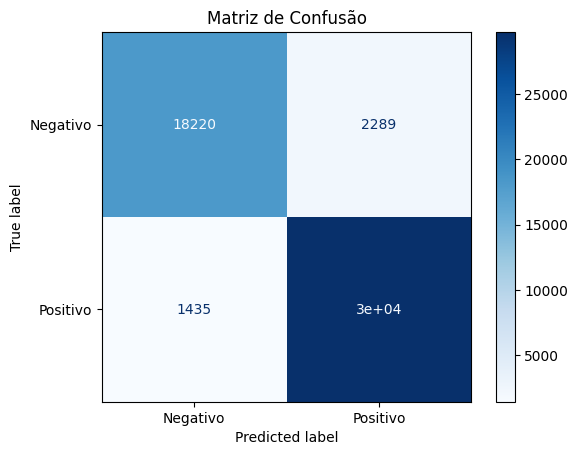

In [ ]:
# Predições no conjunto de teste
y_pred = best_model.predict(X_test)

# Avaliando a acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.2f}")

# Exibindo a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
filename = 'modelo_sentimento_pipeline.joblib'
joblib.dump(best_model, filename)

print(f"Modelo salvo com sucesso em '{filename}'")

Modelo salvo com sucesso em 'modelo_sentimento_pipeline.joblib'


In [4]:
# Em um outro script, ou mais tarde no mesmo...

# 2. CARREGAR O MODELO DO ARQUIVO
loaded_model = joblib.load('/Users/baia/Desktop/PYTHON/repo-dsa/data-science-analytics/reviews-sentiment-analysis/src/modelo_sentimento_pipeline.joblib')
print("Modelo carregado com sucesso!")

# 3. USAR O MODELO CARREGADO PARA FAZER PREVISÕES
novos_reviews = [
    "This film is so good!",
    "Bad experience, the product came broken.",
    "its ok, I kinda like it."
]

previsoes = loaded_model.predict(novos_reviews)
print("\nPrevisões para novos reviews:")
for review, sentimento in zip(novos_reviews, previsoes):
    print(f"- '{review}' -> Sentimento: {sentimento}")

Modelo carregado com sucesso!

Previsões para novos reviews:
- 'This film is so good!' -> Sentimento: Positivo
- 'Bad experience, the product came broken.' -> Sentimento: Negativo
- 'its ok, I kinda like it.' -> Sentimento: Negativo
